In [726]:
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv('train_dataset.csv')

In [727]:
import numpy as np

names_train = ['features_countvec/train_countvec_features_actor_1_name.npy', 'features_countvec/train_countvec_features_actor_2_name.npy', 
               'features_countvec/train_countvec_features_director_name.npy', 'features_doc2vec/train_doc2vec_features_genre.npy',
               'features_doc2vec/train_doc2vec_features_plot_keywords.npy', 'features_fasttext/train_fasttext_title_embeddings.npy']

for name in names_train:
    print(name)
    print(len(np.load(name)[0]))

features_countvec/train_countvec_features_actor_1_name.npy
2063
features_countvec/train_countvec_features_actor_2_name.npy
2919
features_countvec/train_countvec_features_director_name.npy
2113
features_doc2vec/train_doc2vec_features_genre.npy
100
features_doc2vec/train_doc2vec_features_plot_keywords.npy
100
features_fasttext/train_fasttext_title_embeddings.npy
100


In [728]:
def create_columns(len, unique):
    columns = []
    for i in range(len):
        columns.append(str(i + unique))
    return columns

In [729]:
temp1 = np.load('features_countvec/train_countvec_features_actor_1_name.npy')
df_act_1 = pd.DataFrame(temp1, columns=create_columns(len(temp1[0]), 0))

temp2 = np.load('features_countvec/train_countvec_features_actor_2_name.npy')
df_act_2 = pd.DataFrame(temp2, columns=create_columns(len(temp2[0]), len(temp1[0])))

temp3 = np.load('features_countvec/train_countvec_features_director_name.npy')
df_dir = pd.DataFrame(temp3, columns=create_columns(len(temp3[0]), len(temp1[0]) + len(temp2[0])))

temp4 = np.load('features_doc2vec/train_doc2vec_features_genre.npy')
df_genre = pd.DataFrame(temp4, columns=create_columns(len(temp4[0]), len(temp1[0]) + len(temp2[0]) + 100))

temp5 = np.load('features_doc2vec/train_doc2vec_features_plot_keywords.npy')
df_keyword = pd.DataFrame(temp5, columns=create_columns(len(temp5[0]), len(temp1[0]) + len(temp2[0]) + 200))

temp6 = np.load('features_fasttext/train_fasttext_title_embeddings.npy')
df_title = pd.DataFrame(temp6, columns=create_columns(len(temp6[0]), len(temp1[0]) + len(temp2[0]) + 300))

In [730]:
df_list = [df_act_1, df_act_2, df_dir, df_genre, df_keyword, df_title]
pre_data = pd.concat(df_list, axis=1)

data_new = pd.concat([data, pre_data], axis=1)

In [731]:
X_train, X_test, y_train, y_test = train_test_split(data_new.drop(columns='imdb_score_binned'), data_new['imdb_score_binned'], test_size=0.3, random_state=42)
#X_train = X_train.reset_index()
#X_test = X_test.reset_index()
#y_train = y_train.reset_index()
#y_test = y_test.reset_index()

In [732]:
X_train['country'].value_counts()

country
USA              1678
UK                171
France             58
Germany            46
Canada             32
Australia          25
Spain              14
Hong Kong           8
New Zealand         8
Denmark             6
Italy               6
China               5
South Korea         5
Japan               4
Ireland             3
Thailand            3
South Africa        3
Mexico              3
Brazil              2
Romania             2
Norway              2
Netherlands         2
Finland             1
Iran                1
Argentina           1
India               1
Aruba               1
Russia              1
Hungary             1
Chile               1
Poland              1
Belgium             1
Official site       1
West Germany        1
Israel              1
New Line            1
Taiwan              1
Iceland             1
Name: count, dtype: int64

In [733]:
X_train['language'].value_counts()

language
English       2016
French          22
Spanish         11
German           7
Cantonese        5
Mandarin         5
Italian          4
Danish           3
Japanese         3
Thai             2
Portuguese       2
Korean           2
Dutch            2
Norwegian        2
Aboriginal       2
Persian          1
Bosnian          1
Hindi            1
Zulu             1
Hungarian        1
Aramaic          1
Romanian         1
Filipino         1
Maya             1
Hebrew           1
Arabic           1
Kazakh           1
Dari             1
Name: count, dtype: int64

In [734]:
train_pre_data = X_train.iloc[:, 26:]

In [735]:
#from sklearn.decomposition import PCA
#PCs = [200, 400, 600, 800, 1000, 1500, 2000, 3000]
#var = []
#for n in PCs:

#    pca = PCA(n_components=n)

#    df_list = [df_act_1, df_act_2, df_dir, df_genre, df_keyword, df_title]
#    train_pre_data = pd.concat(df_list, axis=1)

#    columns = []
#    for i in range(n):
#        columns.append(str(i))

#    principalComponents = pca.fit_transform(train_pre_data)

#    var.append(np.var(principalComponents))
#import matplotlib.pyplot as plt
#cum_var = np.cumsum(var)

#plt.xlabel('Principal Components')
#plt.ylabel('Cumulative Explained Variance')
#plt.plot(PCs, cum_var)
#plt.show()

In [736]:
# Implement PCA to cut down columns further
from sklearn.decomposition import PCA

pca = PCA(n_components=1000)

columns = []
for i in range(1000):
    columns.append(str(i))

principalComponents = pca.fit_transform(train_pre_data)

df_pca = pd.DataFrame(data=principalComponents, columns=columns)

In [737]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

# Number of rows to reduce sparse matrices to
n=100

selector = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=n, step=10)
X_train_RFE = selector.fit_transform(df_pca, y_train)

In [738]:
#from sklearn.feature_selection import RFECV
#from sklearn.tree import DecisionTreeClassifier

#selector = RFECV(estimator=DecisionTreeClassifier(), step=10, cv=5)
#selector.fit(df_pca, train['imdb_score_binned'])


#print(selector.n_features_)

In [739]:
columns = []
for i in range(n):
    columns.append(str(i))

df_selected_train = pd.DataFrame(data=X_train_RFE, columns=columns)

In [740]:
# Drop old columns and unnecessary columns
titles = ['actor_1_name', 'actor_2_name', 'director_name', 'genres', 'plot_keywords', 'language', 'country', 'id',
            'title_embedding', 'movie_title', 'actor_3_name', 'actor_3_facebook_likes']
df_temp = X_train.iloc[:, :26].drop(columns=titles)
train_new = pd.concat([df_temp.reset_index(), df_selected_train.reset_index()], axis=1)

In [741]:
X_train['content_rating'].value_counts()

content_rating
R            957
PG-13        748
PG           305
G             44
Not Rated     20
Unrated        8
Approved       8
X              7
NC-17          2
M              1
Passed         1
GP             1
Name: count, dtype: int64

In [742]:
# Combine ratings
X_train.loc[X_train.content_rating == 'GP', 'content_rating'] = 'G'
X_train.loc[X_train.content_rating == 'Passed', 'content_rating'] = 'Approved'
X_train.loc[X_train.content_rating == 'NC-17', 'content_rating'] = 'X'
X_train.loc[X_train.content_rating == 'Not Rated', 'content_rating'] = 'Unrated'
X_train.loc[X_train.content_rating == 'M', 'content_rating'] = 'PG-13'

X_train['content_rating'].value_counts()

content_rating
R           957
PG-13       749
PG          305
G            45
Unrated      28
X             9
Approved      9
Name: count, dtype: int64

In [743]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
encoded = enc.fit_transform(X_train[['content_rating']])

df_temp = pd.DataFrame(encoded.toarray(), columns=['Approved', 'G', 'PG', 'PG-13', 'R', 'Unrated', 'X'])

train_final = pd.concat([train_new.drop(columns=['content_rating']), df_temp], axis=1)

In [744]:
# Apply post processing, ie normalisation, standardisation
# Remove outliers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
#scaler = MinMaxScaler()
scaler = StandardScaler()
X_norm = scaler.fit_transform(train_final)

In [745]:
test_pre_data = X_test.iloc[:, 26:]

In [746]:
# Apply fitted PCA to test data
test_pcs = pca.transform(test_pre_data)

columns = []
for i in range(1000):
    columns.append(str(i))

df_pca_test = pd.DataFrame(data=test_pcs, columns=columns)

In [747]:
X_test_RFE = selector.transform(df_pca_test)

In [748]:
columns = []
for i in range(n):
    columns.append(str(i))

df_selected_test = pd.DataFrame(data=X_test_RFE, columns=columns)

In [749]:
test_new = pd.concat([X_test.iloc[:, :26].drop(columns=titles).reset_index(), df_selected_test.reset_index()], axis=1)

print(len(test_new.columns))

116


In [750]:
# Combine ratings
X_test.loc[X_test.content_rating == 'GP', 'content_rating'] = 'G'
X_test.loc[X_test.content_rating == 'Passed', 'content_rating'] = 'Approved'
X_test.loc[X_test.content_rating == 'NC-17', 'content_rating'] = 'X'
X_test.loc[X_test.content_rating == 'Not Rated', 'content_rating'] = 'Unrated'
X_test.loc[X_test.content_rating == 'M', 'content_rating'] = 'PG-13'

encoded = enc.transform(X_test[['content_rating']])

df_temp = pd.DataFrame(encoded.toarray(), columns=['Approved', 'G', 'PG', 'PG-13', 'R', 'Unrated', 'X'])

test_new = pd.concat([test_new.drop(columns='content_rating'), df_temp], axis=1)

In [751]:
X_norm_test = scaler.transform(test_new)

In [752]:
from sklearn.ensemble import GradientBoostingClassifier

In [753]:
GTB = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,
                                 max_depth=5, random_state=0).fit(X_norm, y_train)
y_GTB = GTB.predict(X_norm_test)
df_GTB = pd.DataFrame(y_GTB, columns=['imdb_score_binned'])
df_GTB.insert(0, 'id', range(1, len(df_GTB) + 1))
df_GTB['imdb_score_binned'].value_counts()

imdb_score_binned
2    734
3    142
4     23
1      2
0      1
Name: count, dtype: int64

In [754]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
print(accuracy_score(y_test, y_GTB))
print(f1_score(y_test, y_GTB, average='weighted'))
print(precision_score(y_test, y_GTB, average='weighted'))
print(recall_score(y_test, y_GTB, average='weighted'))
# There is a large label imbalance so we will go with weighted average instead of macro

0.7073170731707317
0.6583788776865859
0.6490924374905149
0.7073170731707317


In [762]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_GTB)

print(cm)

# The confusion matrix suggests that we are getting low values for f1 score due to a lack of data for low ratings.

[[  0   0   6   0   0]
 [  0   1  72   0   0]
 [  0   2 514  36   2]
 [  0   0 110 121   4]
 [  0   0   1  14  19]]


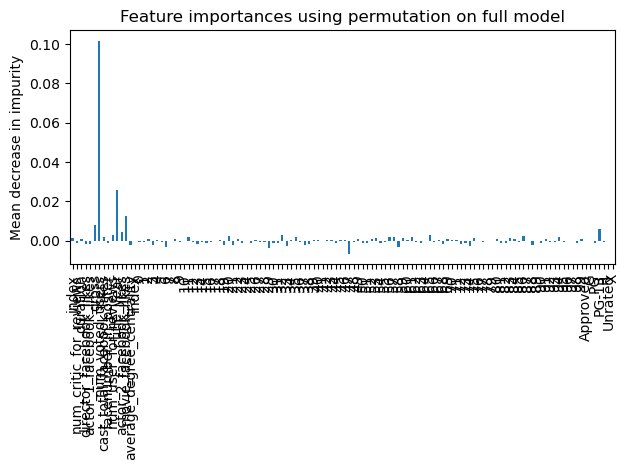

In [756]:
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt
result = permutation_importance(GTB, X_norm_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

gtb_importances = pd.Series(result.importances_mean, index=test_new.columns)

fig, ax = plt.subplots()
gtb_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [757]:
count = 0
remove_features = []
for i in range(len(gtb_importances)):
    if (gtb_importances[i] < 0):
        remove_features.append(test_new.columns[i])
        count = count + 1
print(count)

66


/tmp/ipykernel_128837/2999330604.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (gtb_importances[i] < 0):


In [758]:
print(remove_features)

['num_critic_for_reviews', 'director_facebook_likes', 'actor_1_facebook_likes', 'facenumber_in_poster', 'average_degree_centrality', 'index', '0', '1', '3', '5', '6', '9', '10', '12', '13', '14', '15', '16', '17', '19', '21', '23', '24', '25', '27', '28', '29', '30', '31', '33', '36', '37', '38', '44', '47', '48', '50', '51', '54', '55', '58', '62', '63', '64', '66', '68', '72', '73', '74', '76', '77', '79', '81', '82', '85', '88', '89', '90', '92', '93', '95', '96', '98', 'G', 'PG', 'R']


In [759]:
X_norm_test_dropped = pd.DataFrame(X_norm_test, columns=test_new.columns).drop(columns=remove_features)

X_norm_dropped = pd.DataFrame(X_norm, columns=test_new.columns).drop(columns=remove_features)

In [775]:
GTB_drop = GradientBoostingClassifier(n_estimators=100, learning_rate=0.3,
                                 max_depth=5, random_state=0).fit(X_norm_dropped, y_train)
y_GTB = GTB_drop.predict(X_norm_test_dropped)
df_GTB = pd.DataFrame(y_GTB, columns=['imdb_score_binned'])
df_GTB.insert(0, 'id', range(1, len(df_GTB) + 1))

In [776]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
print(accuracy_score(y_test, y_GTB))
print(f1_score(y_test, y_GTB, average='weighted'))
print(precision_score(y_test, y_GTB, average='weighted'))
print(recall_score(y_test, y_GTB, average='weighted'))
# There is a large label imbalance so we will go with weighted average instead of macro

0.7261640798226164
0.6839973879514798
0.6890445726389244
0.7261640798226164


/home/zac/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [777]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_GTB)

print(cm)

# The confusion matrix suggests that we are getting low values for f1 score due to a lack of data for low ratings.

[[  0   0   6   0   0]
 [  0   1  72   0   0]
 [  0   2 514  36   2]
 [  0   0 110 121   4]
 [  0   0   1  14  19]]


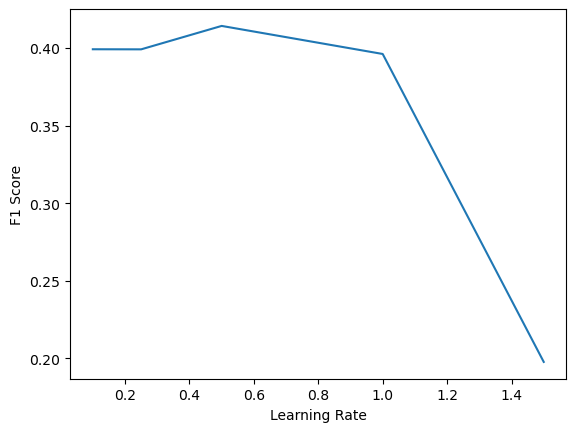

In [764]:
# Evaluate effectiveness of Gradient Boosting model
from matplotlib import pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score


learning_rate = [1.5, 1, 0.5, 0.25, 0.1]
y_pred_learning = []
for rate in learning_rate:
    model = GradientBoostingClassifier(learning_rate=rate).fit(X_norm_dropped, y_train)
    y_pred = model.predict(X_norm_test_dropped)
    y_pred_learning.append(f1_score(y_test, y_pred, average='macro'))

plt.plot(learning_rate, y_pred_learning)
plt.ylabel('F1 Score')
plt.xlabel('Learning Rate')
plt.show()

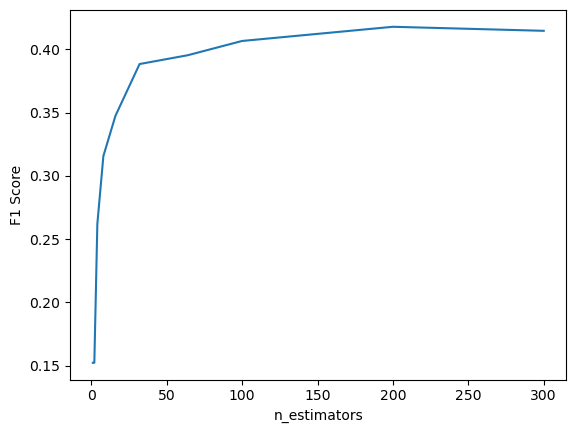

In [771]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200, 300]
y_pred_est = []
for n in n_estimators:
    model = GradientBoostingClassifier(n_estimators=n).fit(X_norm_dropped, y_train)
    y_pred = model.predict(X_norm_test_dropped)
    y_pred_est.append(f1_score(y_test, y_pred, average='macro'))

plt.plot(n_estimators, y_pred_est)
plt.ylabel('F1 Score')
plt.xlabel('n_estimators')
plt.show()

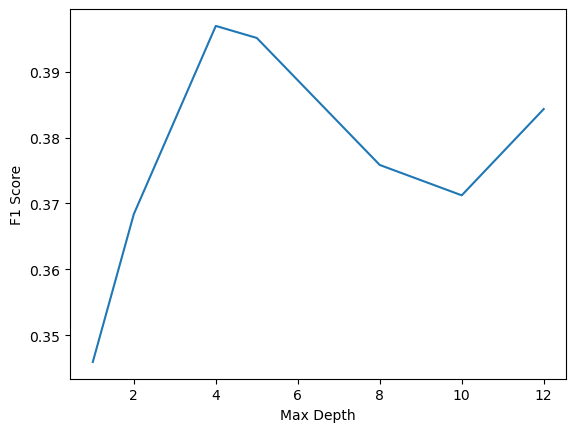

In [724]:
depths = [1, 2, 4, 5, 8, 10, 12]
y_pred_depth = []
for depth in depths:
    model = GradientBoostingClassifier(max_depth=depth).fit(X_norm_dropped, y_train)
    y_pred = model.predict(X_norm_test_dropped)
    y_pred_depth.append(f1_score(y_test, y_pred, average='macro'))

plt.plot(depths, y_pred_depth)
plt.ylabel('F1 Score')
plt.xlabel('Max Depth')
plt.show()

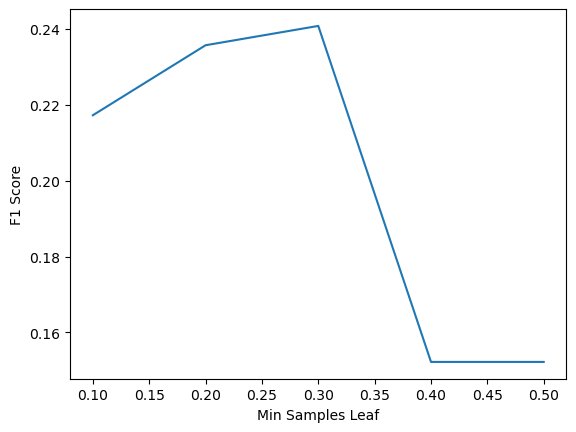

In [659]:
min_samples = np.linspace(0.1, 0.5, 5, endpoint=True)
y_pred_samples = []
for sample in min_samples:
    model = GradientBoostingClassifier(min_samples_leaf=sample).fit(X_norm_dropped, y_train)
    y_pred = model.predict(X_norm_test_dropped)
    y_pred_samples.append(f1_score(y_test, y_pred, average='macro'))

plt.plot(min_samples, y_pred_samples)
plt.ylabel('F1 Score')
plt.xlabel('Min Samples Leaf')
plt.show()

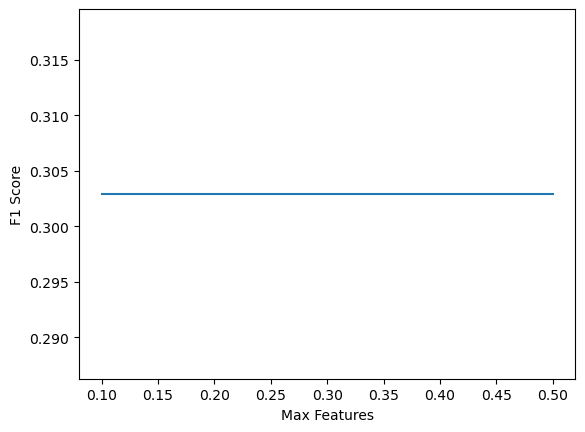

In [660]:
features = np.linspace(0.1, 0.5, 5, endpoint=True)
y_pred_feature = []
for feature in features:
    model = GradientBoostingClassifier(max_features=feature).fit(X_norm_dropped, y_train)
    y_pred = model.predict(X_norm_test_dropped)
    y_pred_feature.append(f1_score(y_test, y_pred, average='macro'))

plt.plot(features, y_pred_feature)
plt.ylabel('F1 Score')
plt.xlabel('Max Features')
plt.show()
# Attempted to set max features to 0.4 but got darastically reduced performance

In [661]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(max_depth=2, random_state=0).fit(X_norm_dropped, y_train)
y_forest = forest.predict(X_norm_test_dropped)

In [662]:
# Base Gradient boosted model is substantially better
print(accuracy_score(y_test, y_forest))
print(f1_score(y_test, y_forest, average='macro'))

0.655210643015521
0.3219583743564085
